# Wiring of a rectifier with a capacitor filter

This example shows how to use PyAEDT to create a Twin Builder design
and run a Twin Builder time-domain simulation.

<img src="_static/rectifier.png" width="500">

Keywords: **Twin Builder**, **rectifier**, **filter**.

## Perform imports and define constants

Perform required imports.

In [1]:
import os
import tempfile
import time

import ansys.aedt.core
import matplotlib.pyplot as plt

Define constants.

In [2]:
AEDT_VERSION = "2025.2"
NUM_CORES = 4
NG_MODE = False  # Open AEDT UI when it is launched.

## Create temporary directory

Create a temporary directory where downloaded data or
dumped data can be stored.
If you'd like to retrieve the project data for subsequent use,
the temporary folder name is given by ``temp_folder.name``.

In [3]:
temp_folder = tempfile.TemporaryDirectory(suffix=".ansys")

## Launch Twin Builder

Launch Twin Builder using an implicit declaration and add a new design with
the default setup.

In [4]:
project_name = os.path.join(temp_folder.name, "TB_Rectifier_Demo.aedt")
tb = ansys.aedt.core.TwinBuilder(
    project=project_name,
    version=AEDT_VERSION,
    non_graphical=NG_MODE,
    new_desktop=True,
)

PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)].


PyAEDT INFO: PyAEDT version 0.25.dev0.


PyAEDT INFO: Initializing new Desktop session.


PyAEDT INFO: Log on console is enabled.


PyAEDT INFO: Log on file C:\Users\ansys\AppData\Local\Temp\pyaedt_ansys_47b46da5-9c1f-46a2-b294-1b877b81270a.log is enabled.


PyAEDT INFO: Log on AEDT is disabled.


PyAEDT INFO: Starting new AEDT gRPC session.


PyAEDT INFO: AEDT installation Path C:\Program Files\ANSYS Inc\v252\AnsysEM


PyAEDT INFO: Client application successfully started.


PyAEDT INFO: New AEDT gRPC session session started on port 50051.


PyAEDT INFO: 2025.2 version started with process ID 5840.


PyAEDT WARNING: Service Pack is not detected. PyAEDT is currently connecting in Insecure Mode.


PyAEDT WARNING: Please download and install latest Service Pack to use connect to AEDT in Secure Mode.


PyAEDT INFO: Debug logger is disabled. PyAEDT methods will not be logged.


PyAEDT INFO: Project TB_Rectifier_Demo has been created.


PyAEDT INFO: No design is present. Inserting a new design.


PyAEDT INFO: Added design 'Twin Builder_MV4' of type Twin Builder.


PyAEDT INFO: Aedt Objects correctly read


## Create components

Place components for a bridge rectifier and a capacitor filter in the schematic editor.

Specify the grid spacing to use for placement
of components in the schematic editor. Components are placed using the named
argument ``location`` as a list of ``[x, y]`` values in millimeters.

In [5]:
G = 0.00254

Create an AC sinosoidal voltage source.

In [6]:
source = tb.modeler.schematic.create_voltage_source(
    "V_AC", "ESINE", 100, 50, location=[-1 * G, 0]
)

PyAEDT INFO: ModelerCircuit class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: ModelerTwinBuilder class has been initialized!


Place the four diodes of the bridge rectifier. The named argument ``angle`` is the rotation angle
of the component in radians.

In [7]:
diode1 = tb.modeler.schematic.create_diode(
    name="D1", location=[10 * G, 6 * G], angle=270
)
diode2 = tb.modeler.schematic.create_diode(
    name="D2", location=[20 * G, 6 * G], angle=270
)
diode3 = tb.modeler.schematic.create_diode(
    name="D3", location=[10 * G, -4 * G], angle=270
)
diode4 = tb.modeler.schematic.create_diode(
    name="D4", location=[20 * G, -4 * G], angle=270
)

Place a capacitor filter.

In [8]:
capacitor = tb.modeler.schematic.create_capacitor(
    name="C_FILTER", value=1e-6, location=[29 * G, -10 * G]
)

Place a load resistor.

In [9]:
resistor = tb.modeler.schematic.create_resistor(
    name="RL", value=100000, location=[39 * G, -10 * G]
)

Place the ground component.

In [10]:
gnd = tb.modeler.components.create_gnd(location=[5 * G, -16 * G])

## Connect components

Connect components with wires, and connect the diode pins to create the bridge.

In [11]:
tb.modeler.schematic.create_wire(
    points=[diode1.pins[0].location, diode3.pins[0].location]
)
tb.modeler.schematic.create_wire(
    points=[diode2.pins[1].location, diode4.pins[1].location]
)
tb.modeler.schematic.create_wire(
    points=[diode1.pins[1].location, diode2.pins[0].location]
)
tb.modeler.schematic.create_wire(
    points=[diode3.pins[1].location, diode4.pins[0].location]
)

Class: ansys.aedt.core.modeler.circuits.object_3d_circuit.Wire

Connect the voltage source to the bridge.

In [12]:
tb.modeler.schematic.create_wire(
    points=[source.pins[1].location, [0, 10 * G], [15 * G, 10 * G], [15 * G, 5 * G]]
)
tb.modeler.schematic.create_wire(
    points=[source.pins[0].location, [0, -10 * G], [15 * G, -10 * G], [15 * G, -5 * G]]
)

Class: ansys.aedt.core.modeler.circuits.object_3d_circuit.Wire

Connect the filter capacitor and load resistor.

In [13]:
tb.modeler.schematic.create_wire(
    points=[resistor.pins[0].location, [40 * G, 0], [22 * G, 0]]
)
tb.modeler.schematic.create_wire(points=[capacitor.pins[0].location, [30 * G, 0]])

Class: ansys.aedt.core.modeler.circuits.object_3d_circuit.Wire

Add the ground connection.

In [14]:
tb.modeler.schematic.create_wire(
    points=[resistor.pins[1].location, [40 * G, -15 * G], gnd.pins[0].location]
)
tb.modeler.schematic.create_wire(points=[capacitor.pins[1].location, [30 * G, -15 * G]])
tb.modeler.schematic.create_wire(points=[gnd.pins[0].location, [5 * G, 0], [8 * G, 0]])

Class: ansys.aedt.core.modeler.circuits.object_3d_circuit.Wire

In [15]:
# Zoom to fit the schematic
tb.modeler.zoom_to_fit()

The circuit schematic should now be visible in the Twin Builder
schematic editor and look like
the image shown at the beginning of the example.

## Run the simulation

Update the total time to be simulated and run the analysis.

In [16]:
tb.set_end_time("100ms")
tb.analyze_setup("TR")

PyAEDT INFO: Solving design setup TR


PyAEDT INFO: Design setup TR solved correctly in 0.0h 0.0m 12.0s


True

## Get report data and plot using Matplotlib

Get report data and plot it using Matplotlib. The following code gets and plots
the values for the voltage on the pulse voltage source and the values for the
voltage on the capacitor in the RC circuit.

PyAEDT INFO: Post class has been initialized! Elapsed time: 0m 0sec


PyAEDT WARNING: No report category provided. Automatically identified Standard


PyAEDT INFO: Solution Data Correctly Loaded.


Time to initialize solution data:0.0
Time to initialize solution data:0.01566767692565918


C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\ansys\aedt\core\visualization\post\solution_data.py:633: UserWarning: Method `data_real` is deprecated. Use :func:`get_expression_data` property instead.
  warnings.warn("Method `data_real` is deprecated. Use :func:`get_expression_data` property instead.")


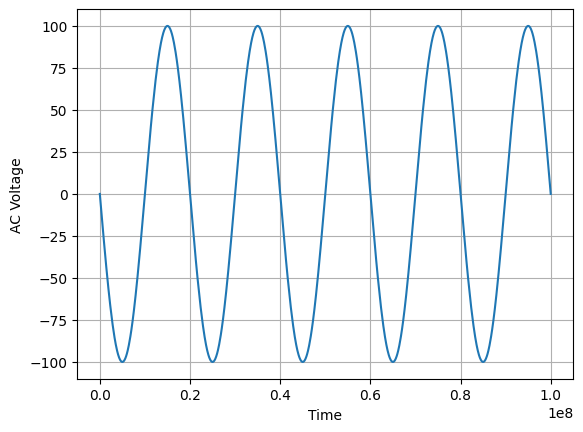

In [17]:
src_name = source.InstanceName + ".V"
x = tb.post.get_solution_data(src_name, "TR", "Time")
plt.plot(x.intrinsics["Time"], x.data_real(src_name))
plt.grid()
plt.xlabel("Time")
plt.ylabel("AC Voltage")
plt.show()

PyAEDT WARNING: No report category provided. Automatically identified Standard


PyAEDT INFO: Solution Data Correctly Loaded.


Time to initialize solution data:0.002913951873779297
Time to initialize solution data:0.002913951873779297


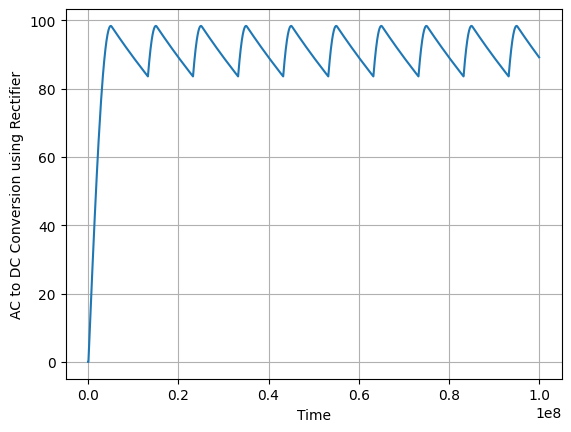

In [18]:
r_voltage = resistor.InstanceName + ".V"
x = tb.post.get_solution_data(r_voltage, "TR", "Time")
plt.plot(x.intrinsics["Time"], x.data_real(r_voltage))
plt.grid()
plt.xlabel("Time")
plt.ylabel("AC to DC Conversion using Rectifier")
plt.show()

## Release AEDT

Release AEDT and close the example.

In [19]:
tb.save_project()
tb.release_desktop()
# Wait 3 seconds to allow AEDT to shut down before cleaning the temporary directory.
time.sleep(3)

PyAEDT INFO: Project TB_Rectifier_Demo Saved correctly


PyAEDT INFO: Desktop has been released and closed.


## Clean up

All project files are saved in the folder ``temp_folder.name``. If you've run this example as a Jupyter notebook, you
can retrieve those project files. The following cell removes all temporary files, including the project folder.

In [20]:
temp_folder.cleanup()